<a href="https://colab.research.google.com/github/Nazerek/face_cartoonization/blob/main/Face_cartoonization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [1]:
!pip install colorthief
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
from PIL import Image
import urllib
import os
import io
from colorthief import ColorThief

In [2]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

--2021-01-06 12:24:12--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  14.0MB/s    in 8.6s    

2021-01-06 12:24:21 (7.13 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



**Functions**

In [3]:
def detect_features(img_gray):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  faces = detector(img_gray)
  for face in faces:
      landmarks = predictor(img_gray, face)
      landmarks_points = []
      for n in range(0, 68):
          x = landmarks.part(n).x
          y = landmarks.part(n).y
          landmarks_points.append((x, y))
  points = np.array(landmarks_points, np.int32)
  return points

In [4]:
def draw_convex(points,image1):
  image=image1.copy()
  mask = np.zeros_like(img_gray)
  convexhull = cv2.convexHull(points)
  cv2.fillConvexPoly(mask, convexhull, 255)
  face_tri = cv2.bitwise_and(image1, image1, mask=mask)
  return mask,face_tri

In [5]:
def get_freq_colors(image_raw):
  tmp_file='kid.jpg'
  face = Image.fromarray(image_raw)
  face.save(tmp_file)
  color_thief = ColorThief(tmp_file)
  dominant_color = color_thief.get_color(quality=5)
  skin_colors=color_thief.get_palette(quality=1)
  skin=skin_colors[0]
  skin_image = np.ones_like(img)*skin
  return skin,skin_image

In [6]:
def draw_lines(points,img):
    pt1 = points[17]
    pt2 = points[18]
    pt3 = points[19]
    pt4 = points[20]
    pt5 = points[21]

    cv2.line(img, tuple(pt1), tuple(pt2), (0, 0, 0), 2);
    cv2.line(img, tuple(pt2), tuple(pt3), (0, 0, 0), 2);
    cv2.line(img, tuple(pt3), tuple(pt4), (0, 0, 0), 2);
    cv2.line(img, tuple(pt4), tuple(pt5), (0, 0, 0), 2);
    return img

In [7]:
def circle_mask(points_cont):
  mask_eye_circle = np.zeros_like(img_gray)
  (x,y),radius = cv2.minEnclosingCircle(points_cont)
  #cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
  center = (int(x),int(y))
  radius = int(radius)
  cv2.circle(mask_eye_circle,center,radius,(255,255,255),-1,8,0)
  #cv2.fillConvexPoly(mask_eye_circle, img_circle, 255);
  return mask_eye_circle

In [8]:
def replace(im_up,im_down,mask_init):
  img1_bg = cv2.bitwise_and(im_up,im_up,mask = mask_init)
  mask_inv = cv2.bitwise_not(mask_init)
  img2_fg = cv2.bitwise_and(im_down,im_down,mask = mask_inv)
  dst = img1_bg+img2_fg
  return img1_bg,img2_fg,dst

In [9]:
def contrast(img):
  lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  cl = clahe.apply(l)
  limg = cv2.merge((cl,a,b))
  final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
  return final

In [10]:
def clustering(image_to_cl,k):
  pixel_vals =image_to_cl.reshape((-1,3)) 
  pixel_vals = np.float32(pixel_vals)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
  retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 
  centers = np.uint8(centers) 
  segmented_data = centers[labels.flatten()]     
  segmented_image = segmented_data.reshape((image_to_cl.shape))     
  return segmented_image

Read image

In [11]:
img_0 = cv2.imread("woman.PNG")[:,:,::-1]
img_gray = cv2.cvtColor(img_0, cv2.COLOR_RGB2GRAY)
img_tri=img_0.copy()
img=img_0.copy()
img_face=img_0.copy()

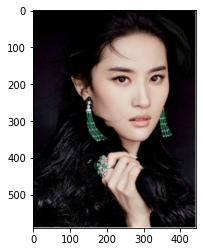

In [12]:
plt.imshow(img_face)

Get points and features

In [13]:
points=detect_features(img_gray)      
convexhull = cv2.convexHull(points) 
eye_left=range(36,42)
eye_right=range(42,48)
eyebrow_left=[17,18,19,20,21,39,40,41,36]
eyebrow_right=[22,23,24,25,26,45,46,47,42]
mouth=range(48,68)
nose=range(27,36)
eye=img_0.copy()
mask_le_circle=circle_mask(points[eyebrow_left])
mask_re_circle=circle_mask(points[eyebrow_right])
mask_lip_circle=circle_mask(points[mouth])
mask_le_convex,im=draw_convex(points[eye_left],eye)
mask_re_convex,im=draw_convex(points[eye_right],eye)
mask_lip_convex,im=draw_convex(points[mouth],eye)
img_le,img2_fg,dst=replace(eye,img,mask_le_circle)
img_re,img2_fg,dst=replace(eye,img,mask_re_circle)
img_le_con,img2_fg,dst=replace(eye,img,mask_le_convex)
img_re_con,img2_fg,dst=replace(eye,img,mask_re_convex)
img_lip,img2_fg,dst=replace(eye,img,mask_lip_convex)
contr_le=contrast(img_le)
contr_re=contrast(img_re)
contr_lip=contrast(img_lip)
lip_clust=clustering(contr_lip,3)
le_clust=clustering(contr_le,3)
re_clust=clustering(contr_re,3)

Face

In [14]:
mask_face,face_tri = draw_convex(points,img_face.copy())

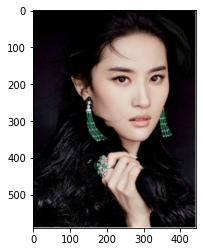

In [15]:
plt.imshow(img_face)

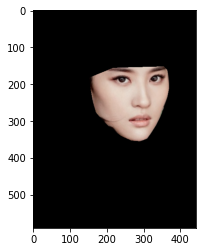

In [16]:
plt.imshow(face_tri)

In [17]:
skin,skin_image=get_freq_colors(face_tri)

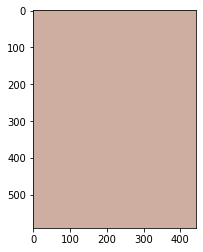

In [18]:
plt.imshow(skin_image)

In [19]:
face_skin = cv2.bitwise_and(skin_image,skin_image, img, mask=mask_face)

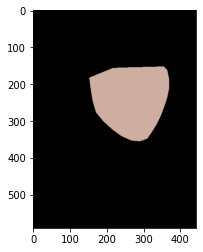

In [20]:
plt.imshow(face_skin)

In [21]:
segmented_image=clustering(face_tri,k=3)

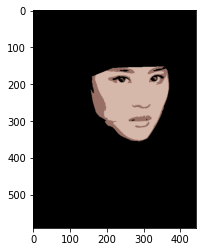

In [22]:
plt.imshow(segmented_image)

In [23]:
blurred = cv2.medianBlur(segmented_image, 3)

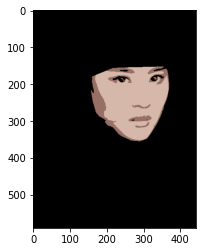

In [24]:
plt.imshow(blurred)

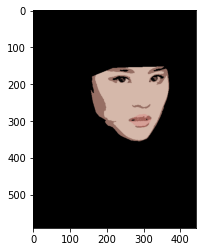

In [25]:
img1_bg,img2_fg,temp=replace(lip_clust,blurred,mask_lip_convex)
img1_bg,img2_fg,temp=replace(le_clust,temp,mask_le_convex)
img1_bg,img2_fg,blurred_edited=replace(re_clust,temp,mask_re_convex)
plt.imshow(blurred_edited)

Get features

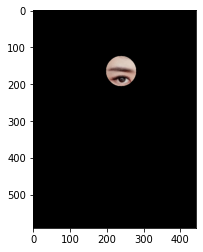

In [26]:
plt.imshow(img_le)

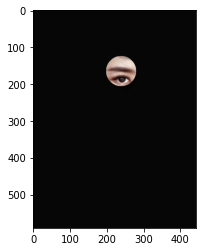

In [27]:
plt.imshow(contr_le)

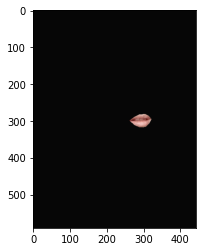

In [28]:
plt.imshow(contr_lip)

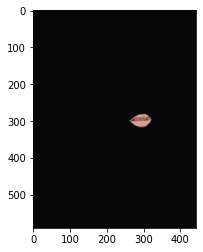

In [29]:
plt.imshow(lip_clust)

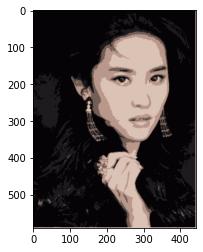

In [30]:
segmented_full=clustering(img_face,5)
blurred_full = cv2.medianBlur(segmented_full, 3)
plt.imshow(blurred_full)

In [31]:
img1_bg,img2_fg,dst_1=replace(lip_clust,blurred_full,mask_lip_convex)
img1_bg,img2_fg,dst_2=replace(le_clust,dst_1,mask_le_convex)
img1_bg,img2_fg,dst_3=replace(re_clust,dst_2,mask_re_convex)

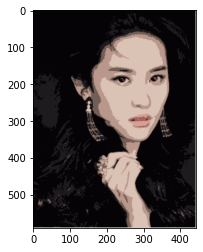

In [32]:
plt.imshow(dst_3)

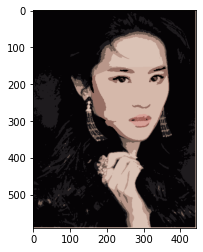

In [33]:
img1_bg,img2_fg,final_image=replace(blurred_edited,blurred_full,mask_face)
plt.imshow(final_image)

In [34]:
(x, y, w, h) = cv2.boundingRect(convexhull)
center = (x + w // 2, y + h // 2)
center

(261, 254)

In [35]:
seamlessclone = cv2.seamlessClone(blurred_edited, blurred_full, mask_face, center, cv2.MIXED_CLONE)
img1_bg,img2_fg,dst_1=replace(lip_clust,seamlessclone,mask_lip_convex)
img1_bg,img2_fg,dst_2=replace(le_clust,dst_1,mask_le_convex)
img1_bg,img2_fg,dst_3=replace(re_clust,dst_2,mask_re_convex)

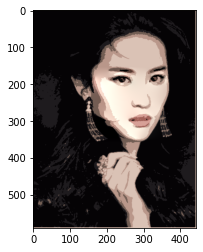

In [36]:
plt.imshow(dst_3)

In [37]:
from ipywidgets import IntSlider, interact, FloatSlider

In [38]:
img_r = cv2.imread("woman.PNG")[:,:,::-1]
img_gray = cv2.cvtColor(img_0, cv2.COLOR_RGB2GRAY)

In [39]:
eye_left=range(36,42)
eye_right=range(42,48)
eyebrow_left=[17,18,19,20,21,39,40,41,36]
eyebrow_right=[22,23,24,25,26,45,46,47,42]
mouth=range(48,68)
nose=range(27,36)

In [55]:
def var_transform(lip_ncolor,eye_ncolor,face_ncolor):
  points=detect_features(img_gray)      
  convexhull = cv2.convexHull(points) 
  eye=img_r.copy()
  #get important features
  mask_le_circle=circle_mask(points[eyebrow_left])
  mask_re_circle=circle_mask(points[eyebrow_right])
  mask_lip_circle=circle_mask(points[mouth])
  mask_le_convex,im=draw_convex(points[eye_left],eye)
  mask_re_convex,im=draw_convex(points[eye_right],eye)
  mask_lip_convex,im=draw_convex(points[mouth],eye)
  # make contrast
  img_le,img2_fg,dst=replace(eye,img,mask_le_circle)
  img_re,img2_fg,dst=replace(eye,img,mask_re_circle)
  img_le_con,img2_fg,dst=replace(eye,img,mask_le_convex)
  img_re_con,img2_fg,dst=replace(eye,img,mask_re_convex)
  img_lip,img2_fg,dst=replace(eye,img,mask_lip_convex)
  contr_le=contrast(img_le)
  contr_re=contrast(img_re)
  contr_lip=contrast(img_lip)
  # choose number of color for features
  lip_clust=clustering(contr_lip,lip_ncolor)
  le_clust=clustering(contr_le,eye_ncolor)
  re_clust=clustering(contr_re,eye_ncolor)
  # replace
  mask_face,face_tri = draw_convex(points,img_r.copy())
  segmented_image=clustering(face_tri,k=3)
  blurred = cv2.medianBlur(segmented_image, face_ncolor)
  img1_bg,img2_fg,temp=replace(lip_clust,blurred,mask_lip_convex)
  img1_bg,img2_fg,temp=replace(le_clust,temp,mask_le_convex)
  img1_bg,img2_fg,blurred_edited=replace(re_clust,temp,mask_re_convex)
  segmented_full=clustering(img_r,face_ncolor)
  blurred_full = cv2.medianBlur(segmented_full, 3)
  img1_bg,img2_fg,dst_1=replace(lip_clust,blurred_full,mask_lip_convex)
  img1_bg,img2_fg,dst_2=replace(le_clust,dst_1,mask_le_convex)
  img1_bg,img2_fg,dst_3=replace(re_clust,dst_2,mask_re_convex)
  #img1_bg,img2_fg,final_image=replace(blurred_edited,blurred_full,mask_face)
  plt.imshow(dst_3)

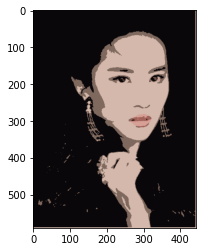

In [57]:
var_transform(3,3,3)

In [58]:
sld_lip_c = IntSlider(value=3, min=2, max=20, step=1, continuous_update=False)
sld_eye_c = IntSlider(value=3, min=2, max=20, step=1, continuous_update=False)
sld_face_c = IntSlider(value=3, min=2, max=20, step=1, continuous_update=False)


In [62]:
interact(var_transform, lip_ncolor=sld_lip_c, eye_ncolor=sld_eye_c,face_ncolor=sld_face_c);

interactive(children=(IntSlider(value=2, continuous_update=False, description='lip_ncolor', max=20, min=2), In…